# About this machine learning project

## Intro

Corona Virus which is commonly known as COVID-19 is an infectious disease that causes illness in the respiratory system in humans. The term Covid 19 is sort of an acronym, derived from “Novel Corona Virus Disease 2019”. Corona Virus has affected our day to day life. This pandemic has affected millions of peoples, who are either sick or are being killed due to the spread of this disease.

Having a machine learning model that can calculate or predict if a patient is in danger when facing this virus can be of major importance becuse it can reduce the time it needs to come up with a diagnose for patients and it can increase the efficiency of the institutions using it.

## Goal

The main goal of this project is to build a machine learning model that, given a Covid-19 patient's current symptom, status, and medical history, will predict whether the patient is in danger or not.

# The dataset

## Context

The dataset was provided by the Mexican government. This dataset contains an enormous number of anonymized patient-related information including pre-conditions. The raw dataset consists of 21 unique features and 1,048,576 unique patients. In the Boolean features, 1 means "yes" and 2 means "no". values as 97 and 99 are missing data.

## Content

sex: 1 for female and 2 for male.
age: of the patient.
result: covid test findings. Values 1-3 mean that the patient was diagnosed with covid in different
degrees. 4 or higher means that the patient is not a carrier of covid or that the test is inconclusive.
patient type: type of care the patient received in the unit. 1 for returned home and 2 for hospitalization.
pneumonia: whether the patient already have air sacs inflammation or not.
pregnancy: whether the patient is pregnant or not.
diabetes: whether the patient has diabetes or not.
copd: Indicates whether the patient has Chronic obstructive pulmonary disease or not.
asthma: whether the patient has asthma or not.
inmsupr: whether the patient is immunosuppressed or not.
hypertension: whether the patient has hypertension or not.
cardiovascular: whether the patient has heart or blood vessels related disease.
renal chronic: whether the patient has chronic renal disease or not.
other disease: whether the patient has other disease or not.
obesity: whether the patient is obese or not.
tobacco: whether the patient is a tobacco user.
usmr: Indicates whether the patient treated medical units of the first, second or third level.
medical unit: type of institution of the National Health System that provided the care.
intubed: whether the patient was connected to the ventilator.
icu: Indicates whether the patient had been admitted to an Intensive Care Unit.
date died: If the patient died indicate the date of death.

# Importing the needed libraries

In [1]:
# Data management
import pandas as pd
import pandas_profiling

# Data preprocessing and trasformation (ETL)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, FunctionTransformer, Binarizer, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from mlxtend.feature_selection import  SequentialFeatureSelector as SFS
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.pipeline import Pipeline as IMBPipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import xgboost as xgb

# Math and Stat modules
import numpy as np
from scipy.stats import loguniform, beta, uniform, sem
import math

# Supervised Learning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate, train_test_split, cross_val_score, cross_val_predict, KFold, StratifiedKFold, RepeatedKFold, ShuffleSplit, StratifiedShuffleSplit, RepeatedStratifiedKFold, learning_curve, validation_curve
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier


# Visualization
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
%matplotlib inline
import warnings

warnings.filterwarnings('ignore')

import itertools

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_675/853257503.py:3: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


# Importing the data

This dataset is too big for my machine to process it so i will be using only one tenth of it. 

In [2]:
data = pd.read_csv('Covid_Data.csv')

data.columns = ['usmer', 'medical_unit', 'sex', 'patient_type', 'date_died', 'intubed', 'pneumonia', 'age',
                'pregnant', 'diabetes', 'copd', 'asthma', 'inmsupr',
                    'hipertension', 'other_disease', 'cardiovascular', 'obesity', 'renal_chronic', 'tabacco', 'result', 'icu']

# replacing all the 2 with zeros for visual effects
df = data[['medical_unit', 'sex', 'patient_type', 'date_died', 
    'intubed', 'pneumonia','pregnant', 'diabetes', 'copd', 'asthma', 
    'inmsupr', 'hipertension', 'other_disease', 'cardiovascular', 
    'obesity', 'renal_chronic', 'tabacco', 'icu']].replace(2, 0)

# Since in our dataset all the values with 98, 97 and 99 are missing values we can replace them with none
df = df[['medical_unit', 'sex', 'patient_type', 'date_died', 
    'intubed', 'pneumonia','pregnant', 'diabetes', 'copd', 'asthma', 
    'inmsupr', 'hipertension', 'other_disease', 'cardiovascular', 
    'obesity', 'renal_chronic', 'tabacco', 'icu']].replace((97, 98, 99), np.nan)
    
# adding the features we didnt change
ss  = StandardScaler()
df['age']  = data['age']
df['usmer'] = data['usmer']

# transforming the target data 
df['result'] = data[['result']].replace((1, 2, 3), 0)
df['result'] = df[['result']].replace((4, 5, 6, 7), 1)

# making sure we select data from all the dataset
df = df[::10]
df

,medical_unit,sex,patient_type,date_died,intubed,pneumonia,pregnant,diabetes,copd,asthma,...,hipertension,other_disease,cardiovascular,obesity,renal_chronic,tabacco,icu,age,usmer,result
0,1.0,1.0,1.0,3/5/20,NaN,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,NaN,65.0,2,0
10,1.0,1.0,1.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,38.0,2,0
20,1.0,0.0,0.0,NaN,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,59.0,2,0
30,1.0,0.0,0.0,NaN,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,2,0
40,1.0,1.0,1.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,37.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048530,13.0,1.0,1.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,34.0,1,1
1048540,13.0,1.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,NaN,80.0,1,1
1048550,13.0,0.0,1.0,NaN,NaN,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,27.0,1,1
1048560,13.0,0.0,1.0,NaN,NaN,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,77.0,1,1


Information about the dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104858 entries, 0 to 1048570
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   medical_unit    104858 non-null  float64
 1   sex             104858 non-null  float64
 2   patient_type    104858 non-null  float64
 3   date_died       7695 non-null    object 
 4   intubed         19379 non-null   float64
 5   pneumonia       103215 non-null  float64
 6   pregnant        104510 non-null  float64
 7   diabetes        104522 non-null  float64
 8   copd            104561 non-null  float64
 9   asthma          104561 non-null  float64
 10  inmsupr         104518 non-null  float64
 11  hipertension    104553 non-null  float64
 12  other_disease   104367 non-null  float64
 13  cardiovascular  104552 non-null  float64
 14  obesity         104553 non-null  float64
 15  renal_chronic   104560 non-null  float64
 16  tabacco         104537 non-null  float64
 17  icu      

In the beggining the boolean value False was represented by the number 2 but we will change that into 0 for a more sandart looking and easy to work dataframe. True will remain 1.

Also our target data has too many values that almost represent the same thing so every value from 1-3 which shows that the patient is not in danger will be turned to 0 and any value that shows that the patient is in dange (4-7) will be turned to 1.

# Explanatory data analysis

## Result

The result indicates whether the patient is in danger or not. As we can see, our results represent the real world in a proper way because the number of patients that are safe is greater than those of endangered patients. 

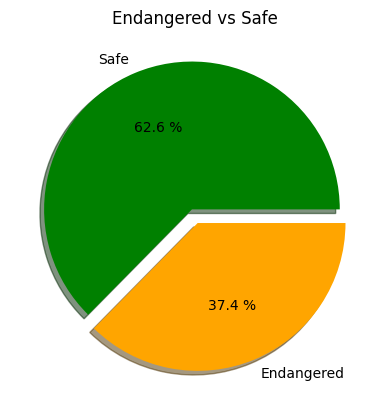

In [4]:
safe_or_not = df['result'].value_counts().tolist()
values = [safe_or_not[0], safe_or_not[1]]
plt.title("Endangered vs Safe")
plt.pie(values, labels= ("Safe","Endangered"), colors= ('green', 'orange'), autopct='%.1f %%', explode=(.05,.05), shadow=True)
plt.show()


## USMER

This measure indicates whether the patient treated medical units of the first, second or third level. As seen below, we have no cases of third level treatments but we can still conclude the more a patient was treated medically the more he is endangered.

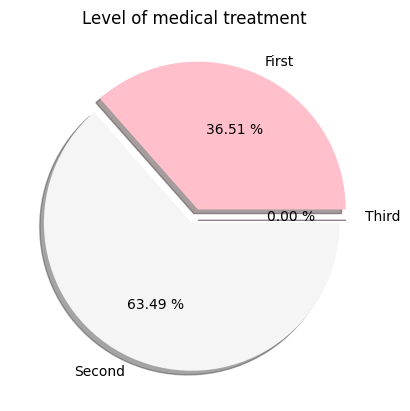

In [5]:
usmer_1 = ((df.loc[df['usmer']==1])['result'] == 1).sum()
usmer_2 = ((df.loc[df['usmer']==2])['result'] == 1).sum()
usmer_3 = ((df.loc[df['usmer']==3])['result'] == 1).sum()

data = (usmer_1,usmer_2, usmer_3)
labels = ('First', 'Second', 'Third')
explode=(.05,.05,.05)
clrs = ('pink', 'whitesmoke', 'purple')

plt.title('Level of medical treatment')
plt.pie(data, labels= labels, colors= clrs, autopct='%.2f %%', explode=explode, shadow=True)
plt.show()

## Medical unit

This feature hold information about which institution of the National Health System provided the care. The classification of this category is from 1 to 3 but the dataset cintains values from 1 to 13 so for me it is hard to find a correlation.

## Sex

This shows the sex of the patients. As we can see from the first graph the data is very balanced, basically we have the same number of females and males. 

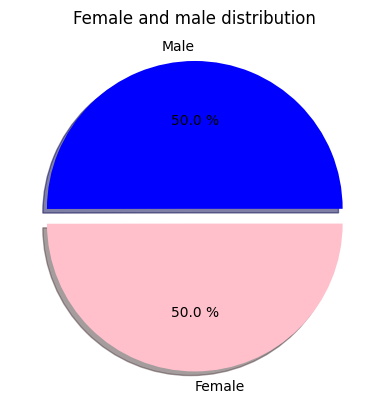

In [6]:
male_or_female = df['sex'].value_counts().tolist()
values = [male_or_female[0], male_or_female[1]]
plt.title("Female and male distribution")
plt.pie(values, labels= ("Male","Female"), colors= ('blue', 'pink'), autopct='%.1f %%', explode=(.05,.05), shadow=True)
plt.show()

And if we compare the danger the patients face according to their gender we can see that females are more endangered to covid.

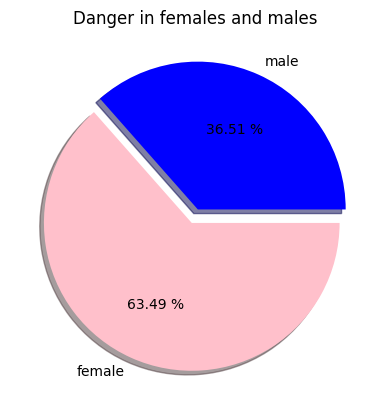

In [7]:
male = ((df.loc[df['sex']==0])['result'] == 1).sum()
female = ((df.loc[df['sex']==1])['result'] == 1).sum()

 
data = (usmer_1,usmer_2)
labels = ('male', 'female')
explode=(.05,.05)
clrs = ('blue', 'pink')

plt.title('Danger in females and males')
plt.pie(data, labels= labels, colors= clrs, autopct='%.2f %%', explode=explode, shadow=True)
plt.show()

## Patient type

This feature indicates whether the patient was sent home or was hospitalized.

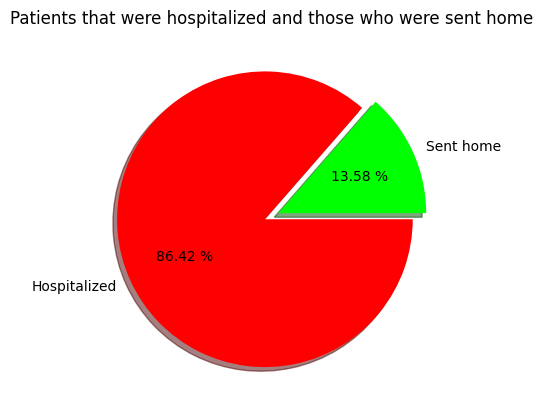

In [8]:
sent_home = ((df.loc[df['patient_type']==0])['result'] == 1).sum()
hospitalized = ((df.loc[df['patient_type']==1])['result'] == 1).sum()

 
data = (sent_home,hospitalized)
labels = ('Sent home', 'Hospitalized')
explode=(.05,.05)
clrs = ('lime', 'red')

plt.title('Patients that were hospitalized and those who were sent home')
plt.pie(data, labels= labels, colors= clrs, autopct='%.2f %%', explode=explode, shadow=True)
plt.show()

We can see that the patients that were hospitalized, meaning they were in a very severe condition were more in danger to covid compared to the ones that stayed home who did not need the same medical help.

## Date died

This feature indicates the date the patient died but this has no significnce.

## Intubed

The imtubed feature indicates whether the patient was intubed or not. According to my research, intubation is done when the patient has very severe problems with the respiratory system so we migh expect tht the patients that were intubed were in far greater danger than the ones that were not.   

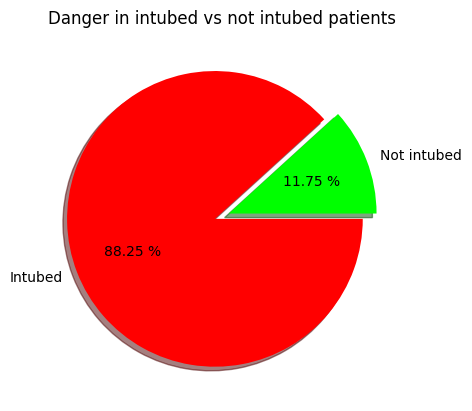

In [9]:
intubed = ((df.loc[df['intubed']==1])['result'] == 1).sum()
not_intubed = ((df.loc[df['intubed']==0])['result'] == 1).sum()

 
data = (intubed, not_intubed)
labels = ('Not intubed', 'Intubed')
explode=(.05,.05)
clrs = ('lime', 'red')

plt.title('Danger in intubed vs not intubed patients')
plt.pie(data, labels= labels, colors= clrs, autopct='%.2f %%', explode=explode, shadow=True)
plt.show()

Just as expected.

## Pneumonia

Pneumonia is an infection that affects one or both lungs. It causes the air sacs, or alveoli, of the lungs to fill up with fluid or pus. Bacteria, viruses, or fungi may cause pneumonia. Since we know that covid attacks the respiratory system first we might expect the same result like in the intubation case. 

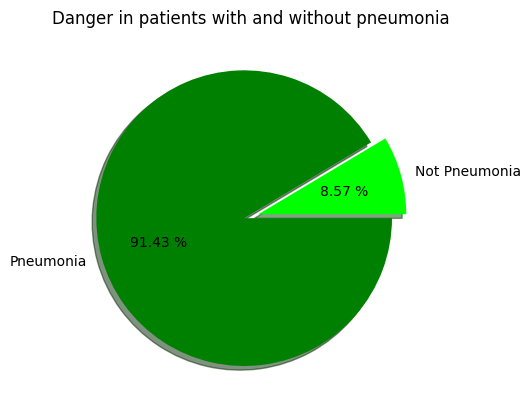

In [10]:
pneumonia = ((df.loc[df['pneumonia']==1])['result'] == 1).sum()
not_pneumonia = ((df.loc[df['pneumonia']==0])['result'] == 1).sum()

 
data = (pneumonia, not_pneumonia)
labels = ('Not Pneumonia', 'Pneumonia')
explode=(.05,.05)
clrs = ('lime', 'green')

plt.title('Danger in patients with and without pneumonia')
plt.pie(data, labels= labels, colors= clrs, autopct='%.2f %%', explode=explode, shadow=True)
plt.show()

## Pregnant

This shows whether the patient was pregnant or not.

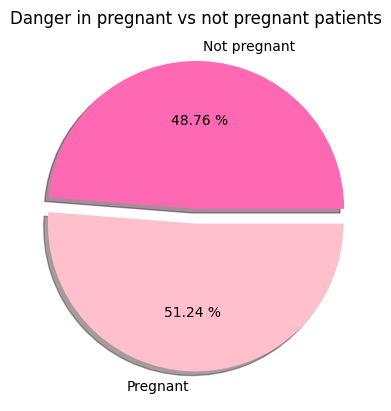

In [11]:
pregnant = ((df.loc[df['pregnant']==1])['result'] == 1).sum()
not_pregnant = ((df.loc[df['pregnant']==0])['result'] == 1).sum()

 
data = (pregnant, not_pregnant)
labels = ('Not pregnant', 'Pregnant')
explode=(.05,.05)
clrs = ('hotpink', 'pink')

plt.title('Danger in pregnant vs not pregnant patients')
plt.pie(data, labels= labels, colors= clrs, autopct='%.2f %%', explode=explode, shadow=True)
plt.show()

Since 50% fo samples are male the number of people that are pregnant is lower but this still affcets the danger increase. With this we can conclude that being pregnant might afect the patients condition while having covid.  

## Diabetes

This measure indicates if a patient has diabetes or not. According to research poeple with diabetes are more likely to have complications due to covid.

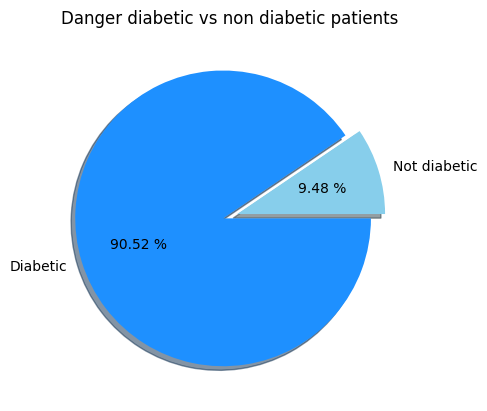

In [12]:
diabetic = ((df.loc[df['diabetes']==1])['result'] == 1).sum()
not_diabetic = ((df.loc[df['diabetes']==0])['result'] == 1).sum()

 
data = (diabetic, not_diabetic)
labels = ('Not diabetic', 'Diabetic')
explode=(.05,.05)
clrs = ('skyblue', 'dodgerblue')

plt.title('Danger diabetic vs non diabetic patients')
plt.pie(data, labels= labels, colors= clrs, autopct='%.2f %%', explode=explode, shadow=True)
plt.show()

As the research suggests, people that have diabetes are more predesposed to have problems when they are facing covid. 

## copd

This indicates whether the patient has chronic obstructive pulmonary disease or not. 

Chronic obstructive pulmonary disease (COPD) is a chronic inflammatory lung disease that causes obstructed airflow from the lungs. Symptoms include breathing difficulty, cough, mucus (sputum) production and wheezing.

Just as in the case of pneumonia we might expect the same results.

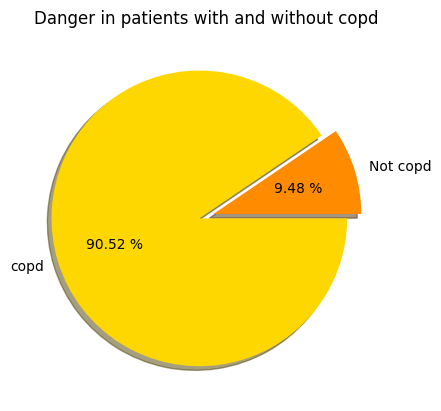

In [13]:
copd = ((df.loc[df['diabetes']==1])['result'] == 1).sum()
not_copd = ((df.loc[df['diabetes']==0])['result'] == 1).sum()

 
data = (copd, not_copd)
labels = ('Not copd', 'copd')
explode=(.05,.05)
clrs = ('darkorange', 'gold')

plt.title('Danger in patients with and without copd')
plt.pie(data, labels= labels, colors= clrs, autopct='%.2f %%', explode=explode, shadow=True)
plt.show()

## Asthma

This indicates whether the paatient has asthma or not. 

Asthma is a disease that affects your lungs. It is one of the most common long-term diseases of children, but adults can have asthma, too. Asthma causes wheezing, breathlessness, chest tightness, and coughing at night or early in the morning.

Just like the other cases with respiratory diseases the results will be the same. 

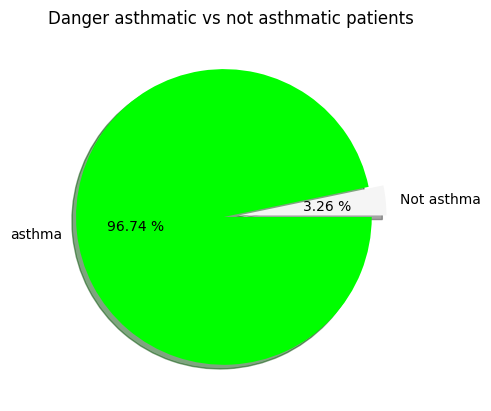

In [14]:
asthma = ((df.loc[df['asthma']==1])['result'] == 1).sum()
not_asthma = ((df.loc[df['asthma']==0])['result'] == 1).sum()

 
data = (asthma, not_asthma)
labels = ('Not asthma', 'asthma')
explode=(.05,.05)
clrs = ('whitesmoke', 'lime')

plt.title('Danger asthmatic vs not asthmatic patients')
plt.pie(data, labels= labels, colors= clrs, autopct='%.2f %%', explode=explode, shadow=True)
plt.show()

## INMSUPR

Indicates whether the patient is immunosuppressed or not

Immunosupression is having a weakened disease system. This means your body is less capeable of fighting viruses that enter the body so we might expect patients with this condition to be more endgangered to covid. 

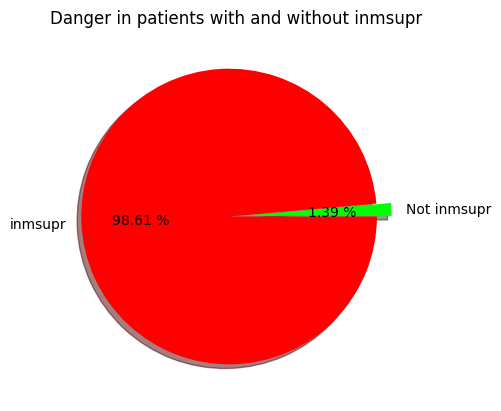

In [15]:
inmsupr = ((df.loc[df['inmsupr']==1])['result'] == 1).sum()
not_inmsupr = ((df.loc[df['inmsupr']==0])['result'] == 1).sum()

 
data = (inmsupr, not_inmsupr)
labels = ('Not inmsupr', 'inmsupr')
explode=(.05,.05)
clrs = ('lime', 'red')

plt.title('Danger in patients with and without inmsupr')
plt.pie(data, labels= labels, colors= clrs, autopct='%.2f %%', explode=explode, shadow=True)
plt.show()

## Hipertension

Hipertension is the term used to describe high blood pressure in the body.

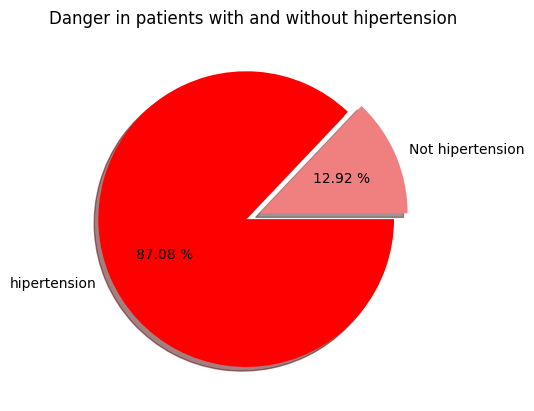

In [16]:
hipertension = ((df.loc[df['hipertension']==1])['result'] == 1).sum()
not_hipertension = ((df.loc[df['hipertension']==0])['result'] == 1).sum()

 
data = (hipertension, not_hipertension)
labels = ('Not hipertension', 'hipertension')
explode=(.05,.05)
clrs = ('lightcoral', 'red')

plt.title('Danger in patients with and without hipertension')
plt.pie(data, labels= labels, colors= clrs, autopct='%.2f %%', explode=explode, shadow=True)
plt.show()

As we can see, patients that have hipertension are more endgangered to covid.  

## Other diseases

Indicates whether the patient has any other types of diseases

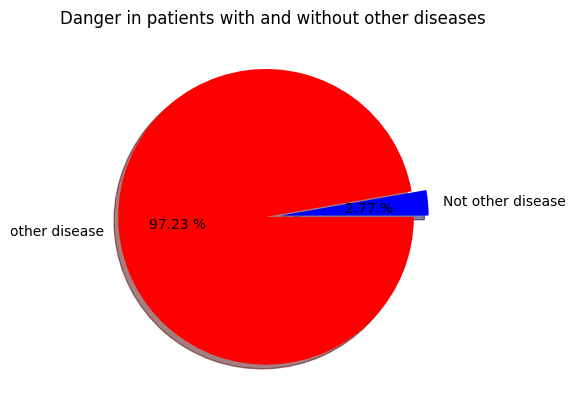

In [17]:
other_disease = ((df.loc[df['other_disease']==1])['result'] == 1).sum()
not_other_disease = ((df.loc[df['other_disease']==0])['result'] == 1).sum()

 
data = (other_disease, not_other_disease)
labels = ('Not other disease', 'other disease')
explode=(.05,.05)
clrs = ('blue', 'red')

plt.title('Danger in patients with and without other diseases')
plt.pie(data, labels= labels, colors= clrs, autopct='%.2f %%', explode=explode, shadow=True)
plt.show()

If a patient has other diseases he is more in danger than e healthy patient. 

## Cardiovascular

This indicates whether the patient has cardiovascular diseases.

Cardiovascular diseases are all the diseases that affect the heart. 

According to the graph below, they seem to have a major role in the increase of danger of a covid patient. 

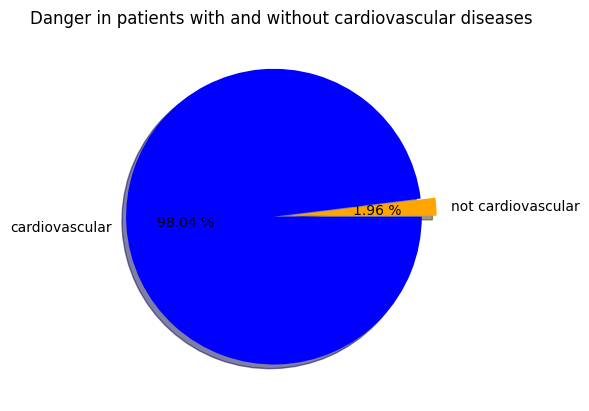

In [18]:
cardiovascular = ((df.loc[df['cardiovascular']==1])['result'] == 1).sum()
not_cardiovascular = ((df.loc[df['cardiovascular']==0])['result'] == 1).sum()

 
data = (cardiovascular, not_cardiovascular)
labels = ('not cardiovascular', 'cardiovascular')
explode=(.05,.05)
clrs = ('orange', 'blue')

plt.title('Danger in patients with and without cardiovascular diseases')
plt.pie(data, labels= labels, colors= clrs, autopct='%.2f %%', explode=explode, shadow=True)
plt.show()

## Obesity

Obesity is the term ued to describe if someone is overweight.

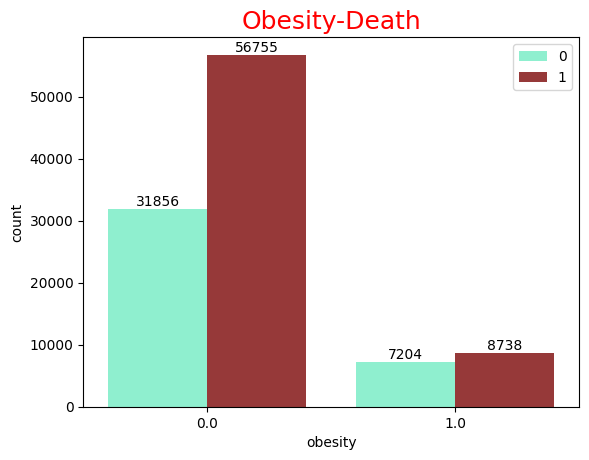

In [19]:
ax=sns.countplot(x=df.obesity,hue=df.result, palette=sns.color_palette(["#7fffd4","#a52a2a"]))
plt.title("Obesity-Death",fontsize=18, color="red")
plt.bar_label(ax.containers[0])
plt.bar_label(ax.containers[1])
plt.legend(loc="best")
plt.show()

Just like any human not healthy condition it contributes to increasing the danger of a fatality from covid.

## Renal chronic

This is a condition in which the kidneys are damaged and cannot filter blood as well as they should. Because of this, excess fluid and waste from blood remain in the body and may cause other health problems, such as heart disease and stroke. We might expect the same results as the other conditions.

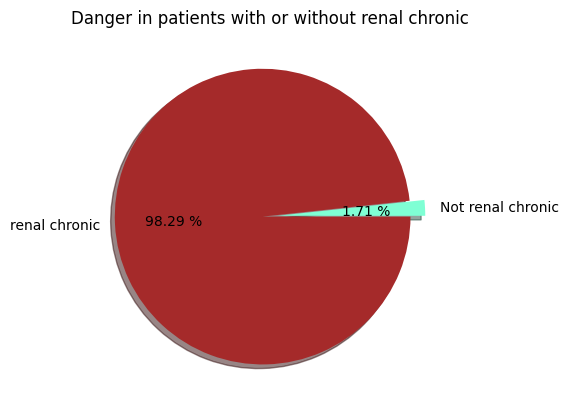

In [20]:
renal_chronic = ((df.loc[df['renal_chronic']==1])['result'] == 1).sum()
not_renal_chronic = ((df.loc[df['renal_chronic']==0])['result'] == 1).sum()

 
data = (renal_chronic, not_renal_chronic)
labels = ('Not renal chronic', 'renal chronic')
explode=(.05,.05)
clrs = ('#7fffd4', '#a52a2a')

plt.title('Danger in patients with or without renal chronic')
plt.pie(data, labels= labels, colors= clrs, autopct='%.2f %%', explode=explode, shadow=True)
plt.show()

## Tabacco

Indicates whether the patient is a smoker or not. Since smoking affects the lungs in a negative manner, we might expect an increase in danger of covid especially when the patinent is a smoker. 

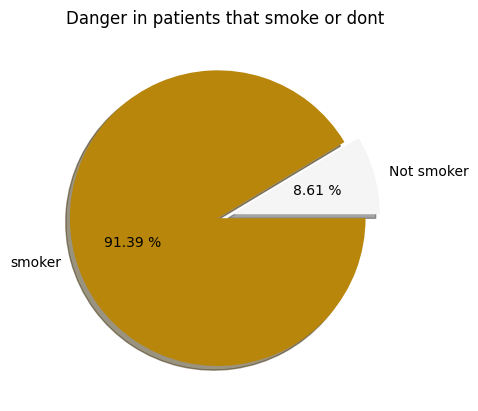

In [21]:
smoker = ((df.loc[df['tabacco']==1])['result'] == 1).sum()
not_smoker = ((df.loc[df['tabacco']==0])['result'] == 1).sum()

 
data = (smoker, not_smoker)
labels = ('Not smoker', 'smoker')
explode=(.05,.05)
clrs = ('whitesmoke', 'darkgoldenrod')

plt.title('Danger in patients that smoke or dont')
plt.pie(data, labels= labels, colors= clrs, autopct='%.2f %%', explode=explode, shadow=True)
plt.show()

## ICU

ICU stands for intensive care unit, also known as an intensive therapy unit or intensive treatment unit or critical care unit, is a special department of a hospital or health care facility that provides intensive care medicine.

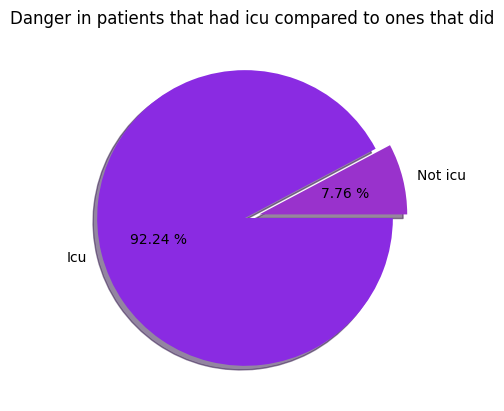

In [22]:
icu = ((df.loc[df['icu']==1])['result'] == 1).sum()
not_icu = ((df.loc[df['icu']==0])['result'] == 1).sum()

 
data = (icu, not_icu)
labels = ('Not icu', 'Icu')
explode=(.05,.05)
clrs = ('darkorchid', 'blueviolet')

plt.title('Danger in patients that had icu compared to ones that did')
plt.pie(data, labels= labels, colors= clrs, autopct='%.2f %%', explode=explode, shadow=True)
plt.show()

We can see that the patients that had  ICU performed in them are more likely to be in danger.

## Age

This indicates the age of the patent. According to research, the older a patient is, more he is in danger of covid. The ages that eperience this phenomen are the ones above 60.

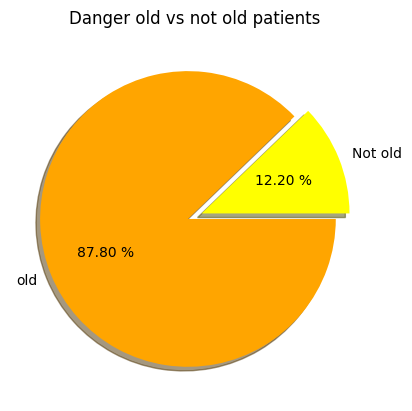

In [23]:
old = ((df.loc[df['age']>59])['result'] == 1).sum()
not_old = ((df.loc[df['age']<=59])['result'] == 1).sum()

 
data = (old, not_old)
labels = ('Not old', 'old')
explode=(.05,.05)
clrs = ('yellow', 'orange')

plt.title('Danger old vs not old patients')
plt.pie(data, labels= labels, colors= clrs, autopct='%.2f %%', explode=explode, shadow=True)
plt.show()

Age distribution.

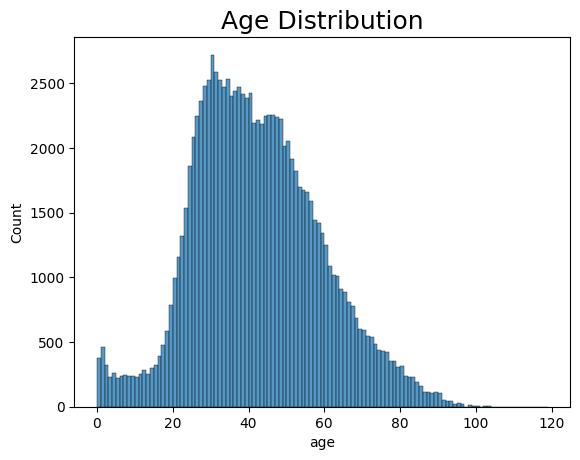

In [24]:
sns.histplot(x=df.age, binwidth=1)
plt.title("Age Distribution", color="black", fontsize=18)
plt.show()

## Plot expenditure features

SHowing the correlation of all the features with the danger.

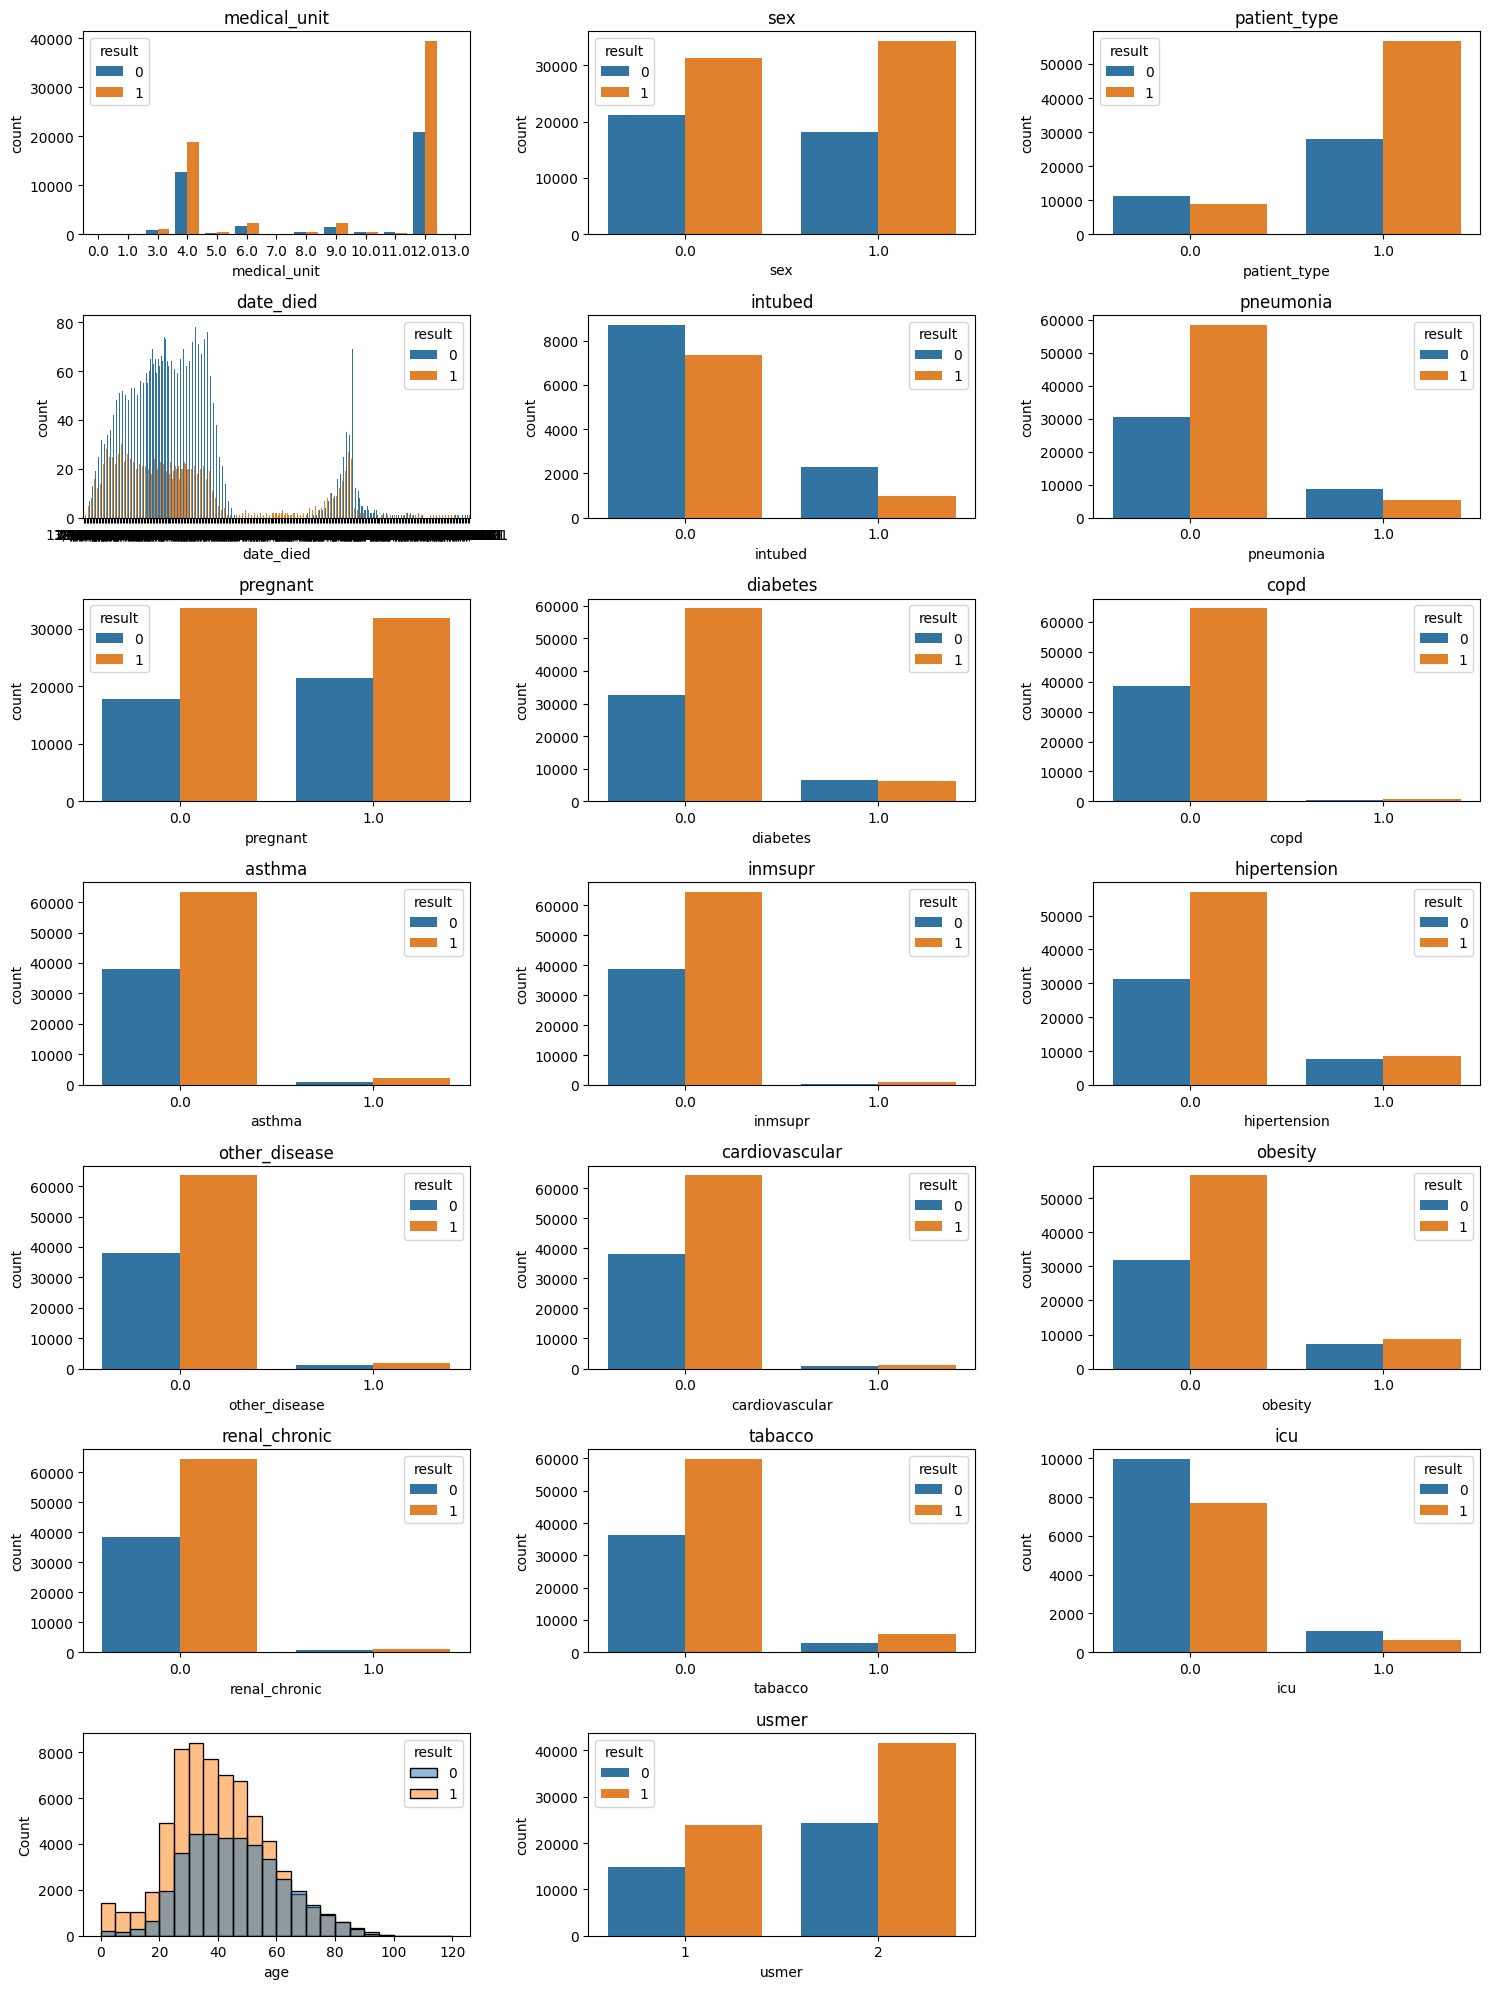

In [25]:

fig=plt.figure(figsize=(15,20))

for i, feature in enumerate(df.drop(['result'], axis=1)):
    ax=fig.add_subplot(7,3,i+1)
    
    if feature == 'age':
       sns.histplot(data=df, x=feature, binwidth=5, axes=ax, hue=df['result'])
    else:
        sns.countplot(data=df, x=feature, axes=ax, hue=df['result'])
        ax.set_title(feature)
     
fig.tight_layout() 
plt.show()

# Data pre-processing

First we see the dimensions of our dataframe.

In [26]:
df.shape

(104858, 21)

Now we check how many missing values we have. 

In [27]:
df.isnull().sum()

medical_unit          0
sex                   0
patient_type          0
date_died         97163
intubed           85479
pneumonia          1643
pregnant            348
diabetes            336
copd                297
asthma              297
inmsupr             340
hipertension        305
other_disease       491
cardiovascular      306
obesity             305
renal_chronic       298
tabacco             321
icu               85497
age                  14
usmer                 0
result                0
dtype: int64

## Dealing with missing data 

The columns that need to be dropped:

1. date_died: too many missing values and it is insignificant to us.

undefined. intubed: too many missing values, more than 80% of the data of this column.

undefined. icu: too many missing values, more than 80% of the data  of this column.

In [28]:
df = df.drop(['date_died', 'intubed', 'icu'], axis='columns')

The amount of missing data in our dataset is almost 5% so we can simply remove the missing values because this wont really affect the dataset.

In [29]:
df.dropna(axis=0, inplace=True)

## Standard scaling

Since age is the only feature that needs scaling, we can just use a standart scaler for it without the need for a pipeline.

We do this because the age feature has a wide range, we bring it to unit variance so the distance between data is smaller. 

In [30]:
sc = StandardScaler()
df['age'] = sc.fit_transform(df[['age']])

In [31]:
X = df.drop(columns=['result'])
y = df['result']

## Dimensionality reduction

Dimensionality reduction, or dimension reduction, is the transformation of data from a high-dimensional space into a low-dimensional space so that the low-dimensional representation retains some meaningful properties of the original data.

This technique is very powerful because it reduces the complexity of the dataset which leads to a smaller computation time. 

For this we wil us XGBClassifier.

In [32]:
xgb = XGBClassifier(n_estimators = 200, 
                    learning_rate=0.1)

xgb.fit(X, y)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [33]:
df_importances = pd.DataFrame(list(X), xgb.feature_importances_)
df_importances.columns = ["Feature_Names"]
df_importances["Importances"] = df_importances.index
df_importances = df_importances.sort_values(by = "Importances", ascending = False)
df_importances.index = np.arange(0,len(df_importances))

Creating a graph to see how much weight each feature has. 

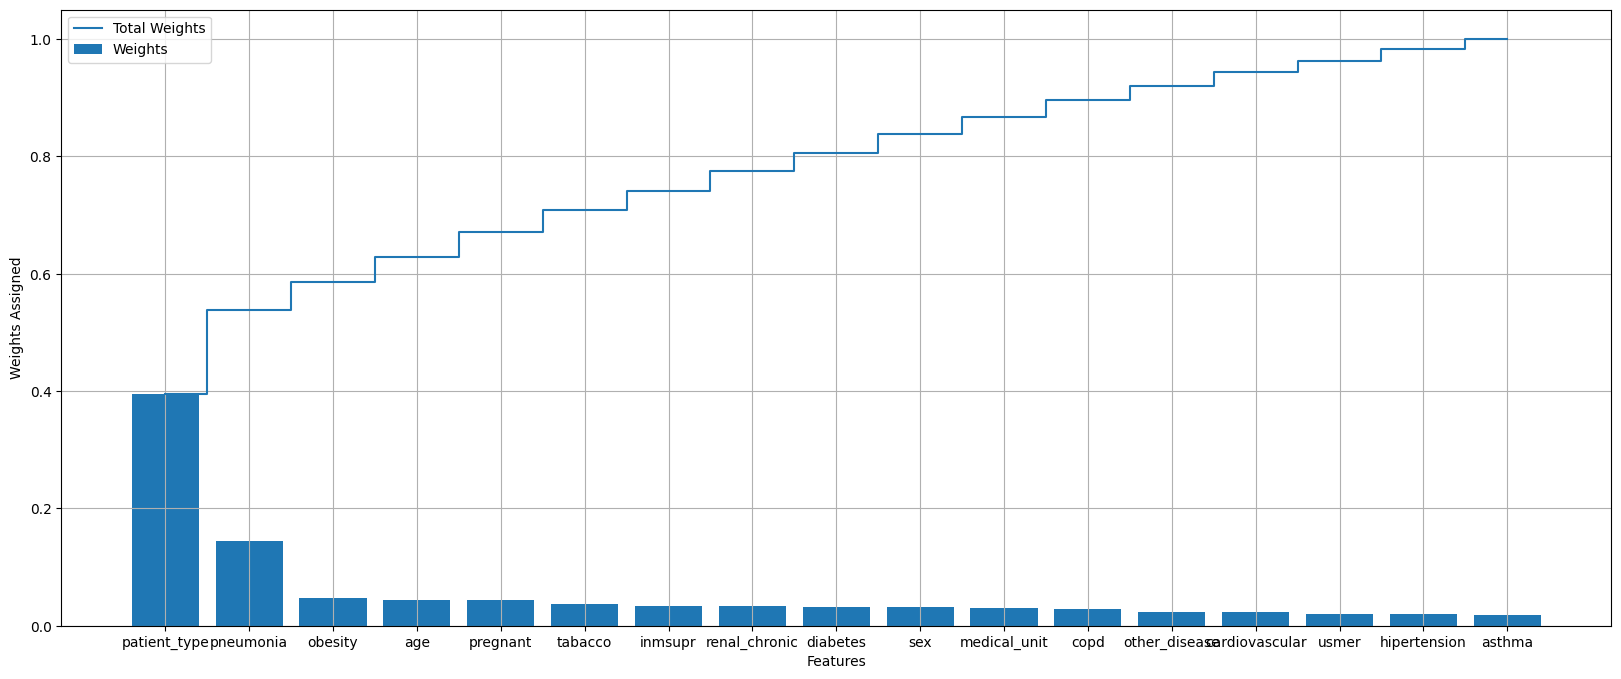

In [34]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot()
cum_evr = np.cumsum(df_importances['Importances'])

ax.bar(df_importances['Feature_Names'],df_importances['Importances'], align='center', label='Weights')
ax.step(df_importances['Feature_Names'], cum_evr, where = 'mid', label='Total Weights')

ax.set_xlabel('Features')
ax.set_ylabel('Weights Assigned')
ax.legend()
ax.grid()
plt.show()

Here we can see that after 0.9 the increase in weight is very small so we can remove all the features after 0.9 with the function below. 

In [35]:
for feat_name, sum_val in zip(df_importances['Feature_Names'], cum_evr):
    if sum_val >= 0.9:
        df = df.drop([feat_name], axis = 1)

Now we can continue to the model selection stage.

# Training and testing

Now we can split into training and testing datasets.

In [36]:
X = df.drop(columns=['result'])
y = df['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=42, shuffle=True)

Creating a model pipeline.

In [37]:
model_pipeline = IMBPipeline([
    ('sampler', SMOTE()), # Sampling method
    ('dim_reduction', PCA(n_components=0.8)), # dimensionality reduction
    ('classifier', Perceptron()) #linear classifier
])

In [38]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('sampler', SMOTE()), ('dim_reduction', PCA(n_components=0.8)),
                ('classifier', Perceptron())])

# Model selection

The models that we will use are:. 

1. Logistic Regression

 Logistic Regression is a statistical method for binary classification problems, where the goal is to predict a binary outcome based on input features. The logistic function is used to model the relationship between the inputs and the binary outcome by mapping real-valued inputs to a probability between 0 and 1. The model is optimized by minimizing a cost function using gradient descent. Once trained, the model can be used to make predictions by computing the predicted probability and thresholding it to make a binary decision. Logistic Regression is simple, fast and provides a probabilistic interpretation of the output.

2. K-Nearest Neighbors (KNN)

 K-Nearest Neighbors (KNN) is a non-parametric method for classification and regression problems. It works by finding the K nearest data points to a new sample in the feature space and classifying the new sample based on the majority class of its K nearest neighbors. KNN has a simple implementation, as it requires no training phase and stores the entire dataset to make predictions. The choice of K is important, as a small K will lead to overfitting, while a large K will lead to underfitting. KNN can handle multi-class problems, non-linear decision boundaries, and can be used for regression by using the mean or median of the K nearest neighbors as the prediction.

3. Random Forest (RF)

 Random Forest is an ensemble machine learning algorithm used for both classification and regression problems. It works by combining multiple decision trees, where each tree is trained on a random subset of the data and a random subset of the features. During prediction, the Random Forest takes a majority vote or takes the average of the outputs from individual trees to make a final prediction. This technique helps reduce overfitting by averaging out the errors made by individual trees and improving the overall model performance.

Since the dataset is too big and the machine im operating on is not very powerful, for simplicity and computational complexity i will be only using these models. 

## Model configurations

In [39]:
sampler_configs = [
    {
        'sampler':[None],
    },
    {
        'sampler':[SMOTE(n_jobs=-1)],
        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
    },
    {
        'sampler':[RandomOverSampler()],
        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
    }
]

dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.5, 0.7, 0.9]
    },
    {
        'dim_reduction': [SFS(estimator=Perceptron(), cv = None, scoring = 'f1')],
        'dim_reduction__estimator': [Perceptron(), LogisticRegression()],
        'dim_reduction__k_features' : [5,7,10]  
    }
]

classifier_configs = [
    {
        'classifier': [LogisticRegression(solver='saga')],
        'classifier__C' : loguniform(0.001,100),
        'classifier__penalty': ['l1','l2'],
        'classifier__class_weight' : [None, 'balanced']

    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3,5,7,9],
        'classifier__weights':['uniform', 'distance']
    },
    {
        'classifier' : [RandomForestClassifier()],
        'classifier__n_estimators' : [10, 50, 100, 500], 
        'classifier__max_depth': [1, 2, 3, None],
        'classifier__class_weight': [None, 'balanced']
    },
]

Creating the configurations dictionary

In [40]:
chosen_configs = [dict(itertools.chain(*(e.items() for e in configuration))) for configuration in itertools.product(sampler_configs,dim_reduction_configs,classifier_configs)]

Using RandomizedSearchCV to find the best configurations for the model.

## Model selection

In [41]:
randomsearch = RandomizedSearchCV(estimator=model_pipeline,
    param_distributions=chosen_configs,
    n_iter=len(chosen_configs),
    n_jobs=-1,
    cv = 2,
    scoring='f1'
)

In [42]:
magaueue glulg glulg glulg

SyntaxError: invalid syntax (1800924255.py, line 1)

Using cross_validate to see the models score across different training and testing subdatasets. 

In [43]:
scores = cross_validate(randomsearch, X_train, y_train, 
                        scoring='f1', cv = 5, return_estimator=True, verbose=3) 
                

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] END ......................................., score=0.771 total time= 3.6min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.6min remaining:    0.0s
[CV] END ......................................., score=0.771 total time= 4.7min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  8.3min remaining:    0.0s
[CV] END ......................................., score=0.766 total time= 5.1min
[CV] END ......................................., score=0.770 total time= 4.4min
[CV] END ......................................., score=0.767 total time= 4.0min
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 21.8min finished


In [44]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

None
SequentialFeatureSelector(cv=None, estimator=Perceptron(), k_features=(10, 10),
                          scoring='f1')
RandomForestClassifier(max_depth=2) {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
0.771217540762763
----------
SMOTE(n_jobs=-1, sampling_strategy=0.7)
None
RandomForestClassifier(max_depth=1) {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'rando

In [45]:
for estimator in scores['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    f1_train = f1_score(y_train, pred_train)
    f1_test = f1_score(y_test, pred_test)
    print(f'F1 on training set:{f1_train}, F1 on test set:{f1_test}')

F1 on training set:0.770848902543663, F1 on test set:0.7727624784853702
F1 on training set:0.7712052441146414, F1 on test set:0.7731179099346855
F1 on training set:0.7679343375673668, F1 on test set:0.7699993339106108
F1 on training set:0.7705194502678779, F1 on test set:0.7722617261399961
F1 on training set:0.7710651976862625, F1 on test set:0.7720269357334322


## Hyperparameter tunning

After a number of attempts we will go with the following parameters:

1. Model: RandomForestClassifier()

undefined. Sampler: Smote()

undefined. Dimensionality reduction techniques: None

In [53]:
best_model_pipeline = IMBPipeline([
    ('sampler', SMOTE(n_jobs=-1, sampling_strategy=0.7)),
    ('classifier', RandomForestClassifier())
])

In [47]:
params = {
    'classifier__n_estimators' : [i for i in range(0,501,50)], 
    'classifier__max_depth': [1, 2, 3],
    'classifier__class_weight': [None, 'balanced']
}

In [48]:
randoms_best = RandomizedSearchCV(
    estimator = best_model_pipeline,
    param_distributions = params,
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2),
    n_iter=5,
    scoring='f1'
)

In [49]:
randoms_best.fit(X_train, y_train)

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=3, random_state=None),
                   estimator=Pipeline(steps=[('sampler',
                                              SMOTE(n_jobs=-1,
                                                    sampling_strategy=0.7)),
                                             ('classifier',
                                              RandomForestClassifier())]),
                   n_iter=5,
                   param_distributions={'classifier__class_weight': [None,
                                                                     'balanced'],
                                        'classifier__max_depth': [1, 2, 3],
                                        'classifier__n_estimators': [0, 50, 100,
                                                                     150, 200,
                                                                     250, 300,
                                                                     350, 400,
                                                                     450,
                                                                     500]},
                   scoring='f1')

In [56]:
f1_score(y_test, randoms_best.best_estimator_.predict(X_test))

0.7708249624632563

In [57]:
cls = randoms_best.best_estimator_

# Model evaluation

## Learning curve 

In [55]:
 train_sizes, train_scores, test_scores = learning_curve(cls,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes= [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                       cv = 5,
                                                       n_jobs = -1,
                                                       scoring = 'f1',
                                                       shuffle = False)

(0.4, 1.03)

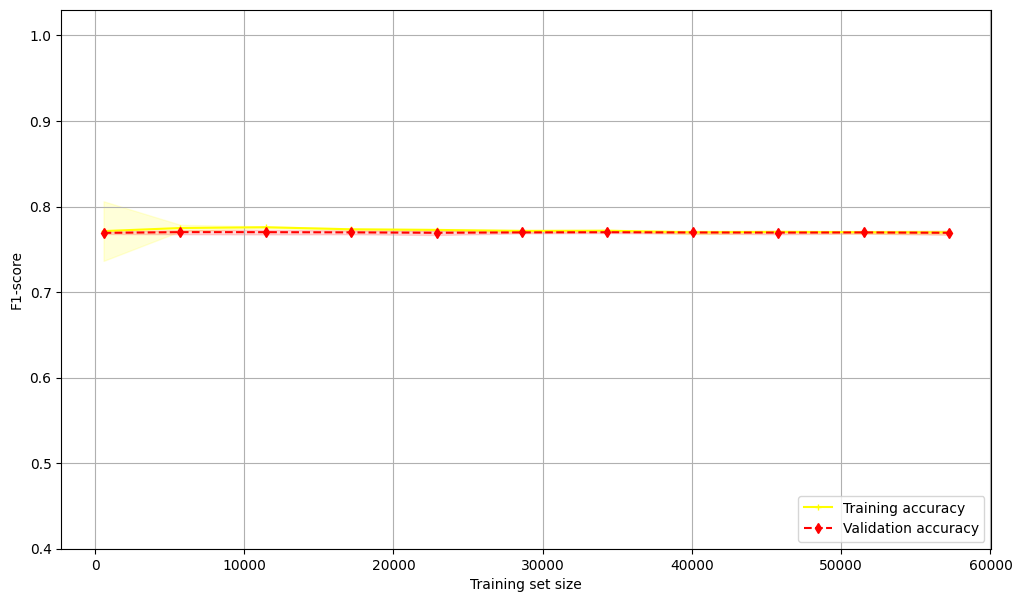

In [58]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(train_sizes, train_mean,
         color='yellow', marker='+',
         markersize=5, label='Training accuracy')

ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='yellow')

ax.plot(train_sizes, test_mean,
         color='red', linestyle='--',
         marker='d', markersize=5,
         label='Validation accuracy')

ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='red')

ax.grid()
ax.set_xlabel('Training set size')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.40, 1.03])

## Confussion matrix

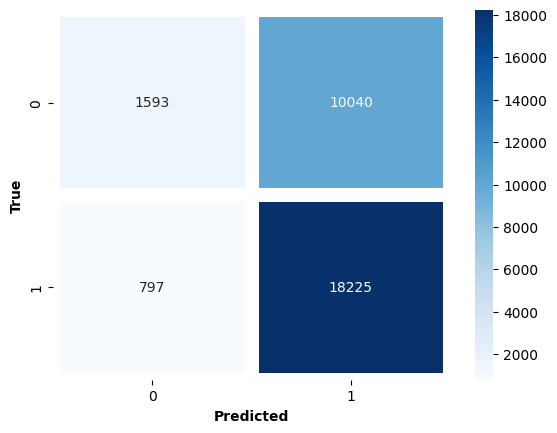

In [59]:
y_pred = randoms_best.best_estimator_.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, linewidths=10, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('True', fontweight='bold')


fig.tight_layout() 
plt.show()

## ROC curve

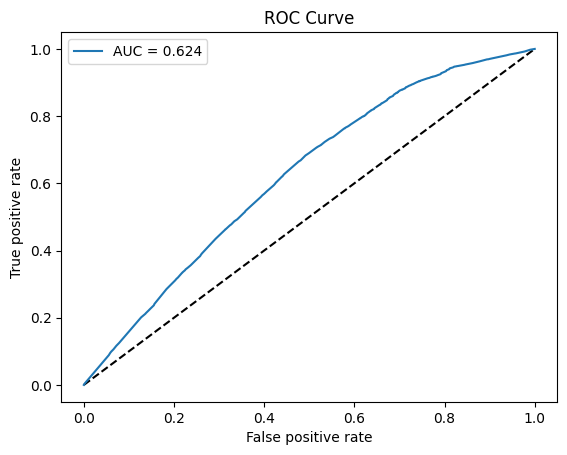

In [60]:
y_pred_prod = randoms_best.best_estimator_.predict_proba(X_test)[:,1]
# Calculate l'AUC
auc = roc_auc_score(y_test, y_pred_prod)
# Calculate coordinates of ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prod)
# ROC Curve Visualization
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))

# True Positive Rate = TP / (TP + FN); Recall
plt.xlabel('False positive rate')

# False Positive Rate = FP / FP + TN; 1 - Recall
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')



fig.tight_layout()
plt.show()

## Classification report 

In [61]:
performances = {
    'accuracy' : accuracy_score,
    'precision' : precision_score,
    'recall' : recall_score,
    'f1' : f1_score,
    'AuC' : roc_auc_score
}

data_sets = {
    'train' : (X_train, y_train),
    'test' : (X_test, y_test)
}

evaluation = {k:[]for k in performances.keys()}
evaluation['data_set'] = []

In [62]:
cls = randoms_best.best_estimator_
cls.fit(*data_sets['train'])

for d_name, d_set in data_sets.items():
    evaluation['data_set'].append(d_name)
    y_pred = cls.predict(d_set[0])
    y_pred_prob = cls.predict_proba(d_set[0])[:,1]
    for perf_name, perf in performances.items():
        if perf_name == 'AuC':
            evaluation[perf_name].append(perf(d_set[1], y_pred_prob))
        else:
            evaluation[perf_name].append(perf(d_set[1], y_pred))
        
df_evaluation = pd.DataFrame(evaluation)
df_evaluation

,accuracy,precision,recall,f1,AuC,data_set
0,0.652094,0.651477,0.944732,0.771166,0.619776,train
1,0.655260,0.653363,0.946693,0.773141,0.622664,test


## Plot validation curve 

In [63]:
range_n_estimator = [i for i in range(0,501, 25)]
train_scores, test_scores = validation_curve(cls,
        X=X_train, 
        y=y_train, 
        param_range= range_n_estimator, 
        param_name='classifier__n_estimators',
        cv=5, 
        n_jobs=-1, 
        scoring='f1'
)

(0.0, 100.0)

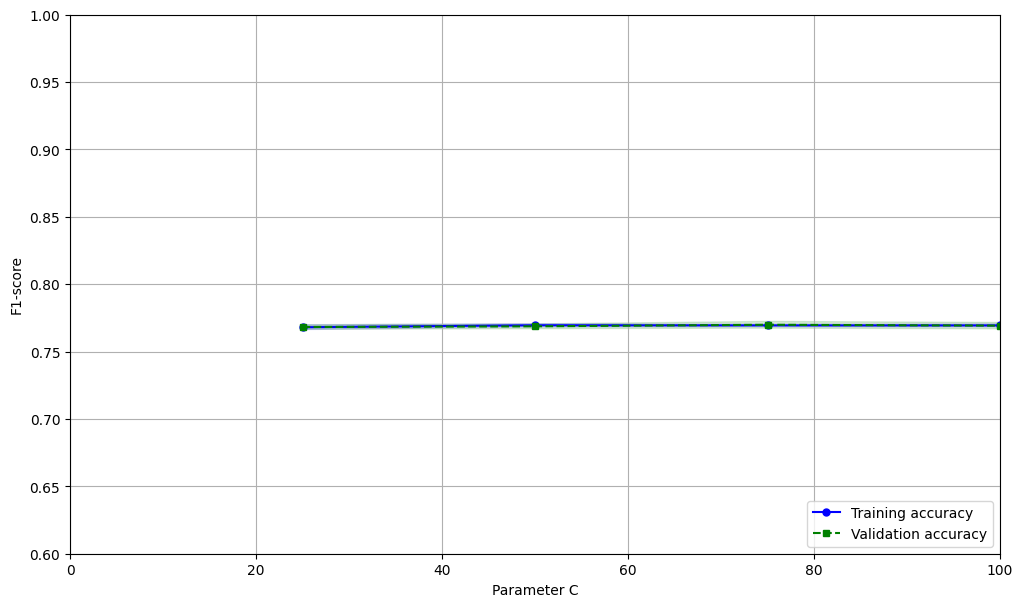

In [64]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(range_n_estimator, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

ax.fill_between(range_n_estimator,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(range_n_estimator, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

ax.fill_between(range_n_estimator,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()

ax.set_xlabel('Parameter C')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.6, 1])

ax.set_xlim([0.00,100])

# Conclusion

This model's f1 score is 0.77 which means it is fairly accuracte model. In the performance metrics, accuracy and precission is lacking a bit but in my opinion this can be fixed with a more sensible choice of models and parameters provided.  

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0fe76447-7935-4120-831d-c0f3ba8ef321' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>